# Load LLM

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
)

# Let's use our built chatbot

In [29]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate
import os
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document

def combine_documents(documents: list[Document]) -> str:
    return "\n\n".join([document.page_content for document in documents])


REPHRASE_SYSTEM_PROMPT = """
<PERSONA>
Eres un especialista resolviendo dudas sobre libros de ficción
</PERSONA>

<TASK>
Tu tarea es refrasear la solicitud del usuario para genera una solicitud refraseada.

- Puedes corregir los errores gramaticales
- Puedes mejorar la semántica y orden léxico de la palabras para un mejor entendimiento
</TASK>
"""

REPHRASE_USER_PROMPT = """{user_request}"""

rephrase_prompt = ChatPromptTemplate([
    SystemMessage(content=REPHRASE_SYSTEM_PROMPT),
    ("user", REPHRASE_USER_PROMPT)
])


QA_SYSTEM_PROMPT = """
<PERSONA>
Eres un especialista resolviendo dudas sobre libros de ficción
</PERSONA>

<TAREA>
Tu tarea es responder la pregunta del usuario.
</TAREA>

<RESTRICCIONES>
- Solo responde la pregunta del usuario tomando como contexto lo provisto en <CONTEXTO>.
</RESTRICCIONES>

<CONTEXTO 1>
{context_1}
</CONTEXTO 1>

<CONTEXTO 2>
{context_2}
</CONTEXTO 2>
"""

QA_USER_PROMPT = """
user question: {user_request}
rephrased user question: {rephrased_request}
"""

qa_prompt = ChatPromptTemplate([
    ("ai", QA_SYSTEM_PROMPT),
    ("user", QA_USER_PROMPT)
])

url = "https://e7f4684c-fd33-4db0-b1d3-268870ecb84d.europe-west3-0.gcp.cloud.qdrant.io:6333"
api_key = os.getenv("QDRANT_API_KEY")

client = QdrantClient(
    url=url,
    api_key=api_key,
    https=True,
    timeout=300
)

vector_store_page = QdrantVectorStore(
    client=client,
    collection_name="db-book-page",
    embedding=OpenAIEmbeddings(model="text-embedding-ada-002"),
)

vector_store_summarized = QdrantVectorStore(
    client=client,
    collection_name="db-book-summarized",
    embedding=OpenAIEmbeddings(model="text-embedding-ada-002"),
)

def debug(x):
    print(x)
    return x

simple_chatbot = (
    {
        "user_request": itemgetter("user_request"),
        "rephrased_request": rephrase_prompt | llm | RunnableLambda(lambda x: x.content)
    }
    | RunnableLambda(debug)
    | RunnablePassthrough() 
    | {
        "user_request": itemgetter("user_request"),
        "rephrased_request": itemgetter("rephrased_request"),
        "context_1": itemgetter("rephrased_request") | vector_store_page.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents),
        "context_2": itemgetter("rephrased_request") | vector_store_summarized.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    }
    | qa_prompt 
    | llm
    | RunnableLambda(lambda x: x.content)
)

In [32]:
simple_chatbot.invoke({"user_request": "hola!"})

{'user_request': 'hola!', 'rephrased_request': '¡Hola! ¿En qué puedo ayudarte hoy?'}


'¡Hola! ¿En qué puedo ayudarte hoy? Si tienes alguna pregunta sobre libros de ficción, estaré encantado de responderla.'

# How we can add memory, let's try another approach

In [6]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

In [7]:
graph.invoke({"messages": [("user", "hi!")]})

{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='029ea6bb-f68f-4226-bf36-01cb252a6fe8'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ff092ab25e', 'finish_reason': 'stop', 'logprobs': None}, id='run-fa1fff12-4c4a-4c22-9bac-cd8f13c94d33-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

# Let's use our vector database

In [12]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def retrieve_pages_context(query: str) -> str:
    """Retrieve information from pages of a book named 'Fortaleza Digital
    Arguments:
        query: Query that a users want to know about the book 
    '"""
    chain = vector_store_page.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    return chain.invoke(query)

@tool
def retrieve_summary_context(query: str) -> str:
    """Retrieve information from summary of pages of a book named 'Fortaleza Digital'
    Arguments:
        query: Query that a users want to know about the book 
    """
    chain = vector_store_summarized.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    return chain.invoke(query)
    

SYSTEM_PROMPT = """
Eres un especialista sobre el libro 'Fortaleza Digital'
"""

def chatbot(state: State):
    llm_with_tools = llm.bind_tools([retrieve_pages_context, retrieve_summary_context])
    return {"messages": [llm_with_tools.invoke([SystemMessage(content=SYSTEM_PROMPT)] + state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

In [14]:
user_question = """
quien es susan fletcher, en el libro Fortaleza digital?
"""
answer = graph.invoke({"messages": [("user", user_question)]})

In [15]:
answer

{'messages': [HumanMessage(content='\nquien es susan fletcher, en el libro Fortaleza digital?\n', additional_kwargs={}, response_metadata={}, id='e3a21c4a-e4b2-4962-91b0-f7d2692048cb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_73E8QzThHpoQxrY8JZix3G1w', 'function': {'arguments': '{"query": "Susan Fletcher en Fortaleza Digital"}', 'name': 'retrieve_pages_context'}, 'type': 'function'}, {'id': 'call_1uwp4qWogZgvcdrHGScYA2rB', 'function': {'arguments': '{"query": "Susan Fletcher en Fortaleza Digital"}', 'name': 'retrieve_summary_context'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 142, 'total_tokens': 197, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'fin

In [18]:
answer["messages"][-1].tool_calls

[{'name': 'retrieve_pages_context',
  'args': {'query': 'Susan Fletcher en Fortaleza Digital'},
  'id': 'call_73E8QzThHpoQxrY8JZix3G1w',
  'type': 'tool_call'},
 {'name': 'retrieve_summary_context',
  'args': {'query': 'Susan Fletcher en Fortaleza Digital'},
  'id': 'call_1uwp4qWogZgvcdrHGScYA2rB',
  'type': 'tool_call'}]

# Let's implement a Tool Call Node

In [19]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def retrieve_pages_context(query: str) -> str:
    """Retrieve information from pages of a book named 'Fortaleza Digital
    Arguments:
        query: Query that a users want to know about the book 
    '"""
    chain = vector_store_page.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    return chain.invoke(query)

@tool
def retrieve_summary_context(query: str) -> str:
    """Retrieve information from summary of pages of a book named 'Fortaleza Digital'
    Arguments:
        query: Query that a users want to know about the book 
    """
    chain = vector_store_summarized.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    return chain.invoke(query)
    

SYSTEM_PROMPT = """
Eres un especialista sobre el libro 'Fortaleza Digital'
"""

def chatbot(state: State):
    llm_with_tools = llm.bind_tools([retrieve_pages_context, retrieve_summary_context])
    return {"messages": [llm_with_tools.invoke([SystemMessage(content=SYSTEM_PROMPT)] + state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[retrieve_pages_context, retrieve_summary_context])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

In [20]:
user_question = """
quien es susan fletcher, en el libro Fortaleza digital?
"""
answer = graph.invoke({"messages": [("user", user_question)]})

In [25]:
for m in answer["messages"]:
    m.pretty_print()

================================ Human Message =================================


quien es susan fletcher, en el libro Fortaleza digital?

================================== Ai Message ==================================
Tool Calls:
  retrieve_pages_context (call_mkPgIuMNnQaQp1kToTIgKXPj)
 Call ID: call_mkPgIuMNnQaQp1kToTIgKXPj
  Args:
    query: Susan Fletcher en Fortaleza Digital
  retrieve_summary_context (call_hen5JzWhsbgaOuTiG4V5Xn2B)
 Call ID: call_hen5JzWhsbgaOuTiG4V5Xn2B
  Args:
    query: Susan Fletcher en Fortaleza Digital
================================= Tool Message =================================
Name: retrieve_pages_context

Dan Brown
La fortaleza digital

Susan Fletcher, la criptógrafa estrella de la ultrasecreta Agencia de
Seguridad Nacional (NSA) no puede dar crédito a sus oídos cuando su jefe,
el subdirector de la Agencia, le informa de que han interceptado un código
que ni siquiera la mayor supercomputadora conocida puede descifrar. La
única pista para romper el l

In [27]:
user_question = """
quien es susan fletcher, quién es david becker y qué relación tienen?
"""
answer = graph.invoke({"messages": [("user", user_question)]})

for m in answer["messages"]:
    m.pretty_print()

================================ Human Message =================================


quien es susan fletcher, quién es david becker y qué relación tienen?

================================== Ai Message ==================================
Tool Calls:
  retrieve_summary_context (call_NQYJ8tNIw5BSl7Clli5Z91mS)
 Call ID: call_NQYJ8tNIw5BSl7Clli5Z91mS
  Args:
    query: Susan Fletcher
  retrieve_summary_context (call_5h3iGRgej0c6cd8gUuPj5vKT)
 Call ID: call_5h3iGRgej0c6cd8gUuPj5vKT
  Args:
    query: David Becker
  retrieve_summary_context (call_d0Dr01c05z3pSKjD3AmISdwM)
 Call ID: call_d0Dr01c05z3pSKjD3AmISdwM
  Args:
    query: relación entre Susan Fletcher y David Becker
================================= Tool Message =================================
Name: retrieve_summary_context

En las páginas 113 a 115, se desarrolla una intensa escena en la que el director de la NSA, Leland Fontaine, se enfrenta a una situación crítica. Fontaine está en una sala de conferencias, donde dos agentes, Colia

# Let's add Memory

In [51]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def search_book_information_in_pages(search_query: str) -> str:
    """Search especific details of the book 'Fortaleza Digital'. Details such as persons and places
    Arguments:
        search_query: Query that a users want to know about the book 
    '"""
    chain = vector_store_page.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    return chain.invoke(search_query)

@tool
def search_book_information_in_summaries(search_query: str) -> str:
    """Search general information of the book 'Fortaleza Digital'. 
    This search can help to get a general knowledge about the book
    Arguments:
        search_query: Query that a users want to know about the book 
    """
    chain = vector_store_summarized.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    return chain.invoke(search_query)
    

SYSTEM_PROMPT = """
Eres un especialista sobre el libro 'Fortaleza Digital'

Restricciones:
- Solo respondes a preguntas sobre el libro usando como contexto la información entregada por las tools.
- Si no tienes el suficiente contexto para responder entonces mencionas que no puedes ayudar con la respuesta

Formato de Respuesta:
- Siempre respondes de forma amable usando emojis
"""

def chatbot(state: State):
    llm_with_tools = llm.bind_tools([retrieve_pages_context, retrieve_summary_context])
    return {"messages": [llm_with_tools.invoke([SystemMessage(content=SYSTEM_PROMPT)] + state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[retrieve_pages_context, retrieve_summary_context])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

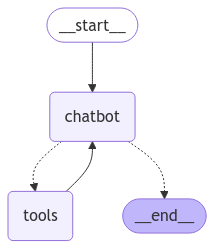

In [48]:
graph

In [52]:
import uuid

user_question = """
donde vive el creador del codigo irrompible en el libro
"""
answer = graph.invoke({"messages": [("user", user_question)]}, config = {"configurable": {"thread_id": str(uuid.uuid4())}})

for m in answer["messages"]:
    m.pretty_print()

================================ Human Message =================================


donde vive el creador del codigo irrompible en el libro

================================== Ai Message ==================================
Tool Calls:
  retrieve_pages_context (call_zPSc1Q9gBy45jwh8hRPO38yj)
 Call ID: call_zPSc1Q9gBy45jwh8hRPO38yj
  Args:
    query: donde vive el creador del código irrompible
  retrieve_summary_context (call_MksthKZaZcBgqgAdAQIuoAqB)
 Call ID: call_MksthKZaZcBgqgAdAQIuoAqB
  Args:
    query: donde vive el creador del código irrompible
================================= Tool Message =================================
Name: retrieve_pages_context

Susan Fletcher, la criptógrafa estrella de la ultrasecreta Agencia de
Seguridad Nacional (NSA) no puede dar crédito a sus oídos cuando su jefe,
el subdirector de la Agencia, le informa de que han interceptado un código
que ni siquiera la mayor supercomputadora conocida puede descifrar. La
única pista para romper el letal código pare

# Let's add another tool

In [55]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def search_book_information_in_pages(search_query: str) -> str:
    """Search especific details of the book 'Fortaleza Digital'. Details such as persons and places
    Arguments:
        search_query: Query that a users want to know about the book 
    '"""
    chain = vector_store_page.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    return chain.invoke(search_query)

@tool
def search_book_information_in_summaries(search_query: str) -> str:
    """Search general information of the book 'Fortaleza Digital'. 
    This search can help to get a general knowledge about the book
    Arguments:
        search_query: Query that a users want to know about the book 
    """
    chain = vector_store_summarized.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    return chain.invoke(search_query)

@tool
def book_a_hotel_reservation(city: str) -> str:
    """Book a hotel reservation in a city"""
    return f"I've booked a reservation in {city}"
    

SYSTEM_PROMPT = """
Eres un especialista sobre el libro 'Fortaleza Digital'

Restricciones:
- Solo respondes a preguntas sobre el libro usando como contexto la información entregada por las tools.
- Si no tienes el suficiente contexto para responder entonces mencionas que no puedes ayudar con la respuesta

Formato de Respuesta:
- Siempre respondes de forma amable usando emojis
"""

def chatbot(state: State):
    llm_with_tools = llm.bind_tools([retrieve_pages_context, retrieve_summary_context, book_a_hotel_reservation])
    return {"messages": [llm_with_tools.invoke([SystemMessage(content=SYSTEM_PROMPT)] + state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[retrieve_pages_context, retrieve_summary_context, book_a_hotel_reservation])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

In [56]:
import uuid

user_question = """
haz una reservación de hotel en el lugar donde nació el creador del código irrompible en el libro
"""
answer = graph.invoke({"messages": [("user", user_question)]}, config = {"configurable": {"thread_id": str(uuid.uuid4())}})

for m in answer["messages"]:
    m.pretty_print()

================================ Human Message =================================


haz una reservación de hotel en el lugar donde nació el creador del código irrompible en el libro

================================== Ai Message ==================================
Tool Calls:
  retrieve_summary_context (call_CByE7zS165bXb8PP53CXnsSW)
 Call ID: call_CByE7zS165bXb8PP53CXnsSW
  Args:
    query: creador del código irrompible
================================= Tool Message =================================
Name: retrieve_summary_context

En este extracto, Susan, una experta en criptografía, se enfrenta a un desafío sin precedentes: un código que el superordenador *Transltr* no puede descifrar. A pesar de que *Transltr* es capaz de probar millones de claves por segundo, este código parece ser indescifrable, lo que desafía el Principio de Bergofsky, que garantiza que cualquier código puede ser roto con suficiente tiempo y recursos. Strathmore, su superior, le revela que el código es producto de 